# PiyushNet and DenseNET for regression!

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10350127346482058627
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9764127309428402834
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9060609213297329211
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15309141407384280643
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10598078219
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12422621792904592560
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10598078219
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2

In [4]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  # Restrict TensorFlow to only use the 2nd and 3rd GPU
  try:
    gpu_list = [gpus[0],gpus[1]]
    tf.config.experimental.set_visible_devices(gpu_list, 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

print(logical_gpus)

gpu_list = ["/gpu:0", "/gpu:1"]
print(gpu_list)
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 2 Logical GPU
[LogicalDevice(name='/job:localhost/replica:0/task:0/device:GPU:0', device_type='GPU'), LogicalDevice(name='/job:localhost/replica:0/task:0/device:GPU:1', device_type='GPU')]
['/gpu:0', '/gpu:1']
Number of devices: 2


In [5]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/home/mswiatlowski/start_tf/caloml-atlas-new/'
plotpath = path_prefix+'regression/Plots/'
modelpath = path_prefix+'regression/Models/'


In [6]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

Using TensorFlow backend.


In [7]:
inputpath = '/fast_scratch/atlas_images/v7/'
# rootfiles = ["pi0", "piplus", "piminus"]
rootfiles = ["piplus"]

trees, pdata = mu.setupPionData(inputpath, rootfiles)
npp = len(pdata['piplus'])
print("Number of pi+ events: {}".format(npp))


Number of pi+ events: 435967


In [8]:
pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False, energyScale = 'clusterE', energyFrame = pdata[ifile])
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

The above are images normalized to energy scale. Neat.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras as keras
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K

In [10]:
def stretched_tanh(x):
    beta = 5
    return beta*K.tanh(x)

In [65]:
def merged_model(droprate=.5):
    with strategy.scope():
        # EMB1 image (convolutional)
        input1 = Input(shape=(128,4,1), name='emb1_input')
        x1 = Convolution2D(32, (3, 3), padding='same', name='emb1_conv2d_1')(input1)
        x1 = Activation('relu')(x1)
        # x1 = Dropout(droprate)(x1)
        x1 = Convolution2D(32, (3, 3), padding='same', name='emb1_conv2d_2')(x1)
        x1 = Activation('relu')(x1)
        x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_3')(x1)
        x1 = Convolution2D(64, (3, 3), padding='same', name='emb1_conv2d_3')(x1)
        x1 = Activation('relu')(x1)
        #x1 = Dropout(droprate)(x1)
        x1 = Convolution2D(64, (3, 3), padding='same', name='emb1_conv2d_4')(x1)
        x1 = Activation('relu')(x1)
        x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_5')(x1)
        x1 = Convolution2D(128, (2, 2), padding='same', name='emb1_conv2d_6')(x1)
        x1 = Activation('relu')(x1)
        x1 = Convolution2D(128, (2, 2), padding='same', name='emb1_conv2d_7')(x1)
        x1 = Activation('relu')(x1)
        x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_8')(x1)
        x1 = Dropout(droprate, name='emb1_dropout_4')(x1)
        x1 = Flatten(name='emb1_flatten_9')(x1)
        x1 = Dense(128, activation='relu', name='emb1_dense_9')(x1)

        # EMB23 image (convolutional)
        input2 = Input(shape=(16,16,2), name='emb23_input')
        x2 = Convolution2D(32, (1, 1), padding='same', name='emb23_conv1d_1')(input2)
        x2 = Activation('relu')(x2)
        # x2 = Dropout(droprate)(x2)
        x2 = Convolution2D(64, (2, 2), padding='same', name='emb23_conv2d_2')(x2)
        # x2 = Dropout(droprate)(x2)
        x2 = MaxPool2D(pool_size=(2, 2), padding='same', name='emb23_maxpool_3')(x2)
        x2 = Convolution2D(128, (2, 2), padding='same', name='emb23_conv2d_4')(x2)
        x2 = Activation('relu')(x2)
        # x2 = Dropout(droprate)(x2)
        x2 = Convolution2D(128, (2, 2), padding='same', name='emb23_conv2d_5')(x2)
        x2 = Activation('relu')(x2)
        x2 = MaxPool2D(pool_size=(2, 2), padding='same', name='emb23_maxpool_6')(x2)
        x2 = Dropout(droprate, name='emb23_dropout_4')(x2)
        x2 = Flatten(name='emb23_flatten_7')(x2)
        x2 = Dense(128, activation='relu', name='emb23_dense_8')(x2)

        # tiles image (convolutional)
        input3 = Input(shape=(4,4,3), name='tiles_input')
        x3 = Convolution2D(32, (1, 1), padding='same', name='tiles_conv1d_1')(input3)
        x3 = Activation('relu')(x3)
        # x3 = Dropout(droprate)(x3)
        x3 = Convolution2D(64, (2, 2), padding='same', name='tiles_conv2d_2')(x3)
        x3 = Activation('relu')(x3)
        # x3 = Dropout(droprate)(x3)
        x3 = Convolution2D(128, (2, 2), padding='same', name='tiles_conv2d_3')(x3)
        x3 = Activation('relu')(x3)
        x3 = MaxPool2D(pool_size=(2, 2), padding='same', name='tiles_maxpool_4')(x3)
        x3 = Dropout(droprate, name='tiles_dropout_4')(x3)
        x3 = Flatten(name='tiles_flatten_5')(x3)
        x3 = Dense(128, activation='relu', name='tiles_dense_6')(x3)

        # concatenate outputs from the two networks above
        x = concatenate([x1, x2, x3], name='concatenate') 
        x = Dropout(droprate, name='concate_dropout_5')(x)
        x = Dense(64, name='concated_dense_1')(x)    
        x = Activation('relu')(x)
        x = Dropout(droprate, name='dense_dropout_6')(x)

        # final output
        output = Dense(1, activation=stretched_tanh, name='dense_output')(x)
        # output = 5*tf.math.tanh(x)   # 0 to +5 range

        model = Model(inputs = [input1, input2, input3], outputs = [output])

        # compile model
        # model = multi_gpu_model(model, gpus=4)
        opt = Adam(lr=1e-5)
        model.compile(loss='mse', optimizer=opt, metrics=['mae', 'mse'])
        return model

In [12]:
training_classes = ['piplus']
pp, pp_cells, pp_label = mu.createTrainingDatasets(training_classes, pdata, pcells)

In [41]:
mu.addCleaning(pp, pp_cells)

In [20]:
pcellsE23_EMB2G_channels = mu.setupChannelImages(mu.rescaleImages(pp_cells, (16, 16), layers=['EMB2', 'EMB3']),last=True)
pcellsE1_EMB1G_channels = mu.setupChannelImages(mu.rescaleImages(pp_cells, (128, 4), layers=['EMB1']),last=True)
pcellsT123_T1G_channels = mu.setupChannelImages(mu.rescaleImages(pp_cells, (4, 4), layers=['TileBar0', 'TileBar1', 'TileBar2']),last=True)

In [21]:
pp['logECalib'] = np.log10(pp.cluster_ENG_CALIB_TOT)


In [22]:
def norm(x, xmax, xmin):
    xmin = xmin - np.finfo(np.float32).eps
    return (x-xmin)/(xmax-xmin)

def denorm(x, xmax, xmin):
    xmin = xmin - np.finfo(np.float32).eps
    return x*(xmax-xmin) + xmin

In [23]:
calib_max = np.amax(pp.logECalib)
calib_min = np.amin(pp.logECalib)
pp['s_logECalib'] = norm(pp.logECalib, xmax = calib_max, xmin = calib_min)

In [43]:
np.count_nonzero(pp.cleanLeading)

218260

In [66]:
model_p1_d02 = merged_model(0.2)
model_p1_d02.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb1_input (InputLayer)         [(None, 128, 4, 1)]  0                                            
__________________________________________________________________________________________________
emb1_conv2d_1 (Conv2D)          (None, 128, 4, 32)   320         emb1_input[0][0]                 
__________________________________________________________________________________________________
activation_52 (Activation)      (None, 128, 4, 32)   0           emb1_conv2d_1[0][0]              
__________________________________________________________________________________________________
emb1_conv2d_2 (Conv2D)          (None, 128, 4, 32)   9248        activation_52[0][0]              
____________________________________________________________________________________________

In [67]:
history_p1_d02 = model_p1_d02.fit([pcellsE1_EMB1G_channels[pp.train & pp.cleanEmpty], 
                                pcellsE23_EMB2G_channels[pp.train & pp.cleanEmpty], 
                                pcellsT123_T1G_channels[pp.train & pp.cleanEmpty]],
                                pp[pp.train & pp.cleanEmpty].s_logECalib.to_numpy(),
                                validation_data=([pcellsE1_EMB1G_channels[pp.val & pp.cleanEmpty], 
                                                    pcellsE23_EMB2G_channels[pp.val & pp.cleanEmpty], 
                                                    pcellsT123_T1G_channels[pp.val & pp.cleanEmpty]], 
                                                    pp[pp.val & pp.cleanEmpty].s_logECalib.to_numpy()),
                                epochs=250,
                                batch_size = 128*ngpu,
                                verbose=2
                                # use_multiprocessing=False
                                )

 mse: 0.0061 - val_loss: 0.0020 - val_mae: 0.0323 - val_mse: 0.0020
Epoch 100/250
296439/296439 - 22s - loss: 0.0061 - mae: 0.0548 - mse: 0.0061 - val_loss: 0.0021 - val_mae: 0.0332 - val_mse: 0.0021
Epoch 101/250
296439/296439 - 22s - loss: 0.0061 - mae: 0.0547 - mse: 0.0061 - val_loss: 0.0021 - val_mae: 0.0333 - val_mse: 0.0021
Epoch 102/250
296439/296439 - 22s - loss: 0.0061 - mae: 0.0547 - mse: 0.0061 - val_loss: 0.0022 - val_mae: 0.0348 - val_mse: 0.0022
Epoch 103/250
296439/296439 - 22s - loss: 0.0060 - mae: 0.0545 - mse: 0.0060 - val_loss: 0.0021 - val_mae: 0.0338 - val_mse: 0.0021
Epoch 104/250
296439/296439 - 22s - loss: 0.0060 - mae: 0.0542 - mse: 0.0060 - val_loss: 0.0022 - val_mae: 0.0345 - val_mse: 0.0022
Epoch 105/250
296439/296439 - 22s - loss: 0.0060 - mae: 0.0541 - mse: 0.0060 - val_loss: 0.0021 - val_mae: 0.0335 - val_mse: 0.0021
Epoch 106/250
296439/296439 - 22s - loss: 0.0060 - mae: 0.0542 - mse: 0.0060 - val_loss: 0.0020 - val_mae: 0.0328 - val_mse: 0.0020
Epoch 10

In [69]:
pp['predict_p1_d02'] = 10.**(denorm(model_p1_d02.predict([pcellsE1_EMB1G_channels, pcellsE23_EMB2G_channels, pcellsT123_T1G_channels]), xmax = calib_max, xmin = calib_min))
pp['predict_p1_d02_EoverCalib'] = pp.predict_p1_d02 / pp.cluster_ENG_CALIB_TOT

<Figure size 576x432 with 0 Axes>

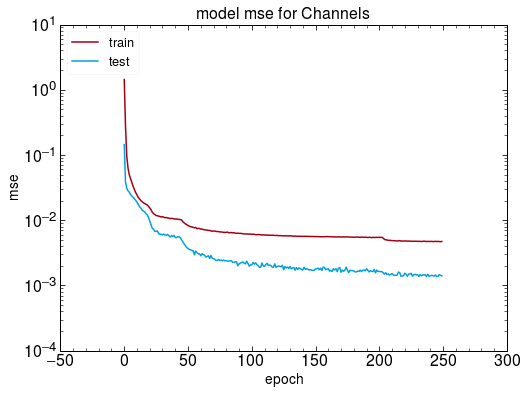

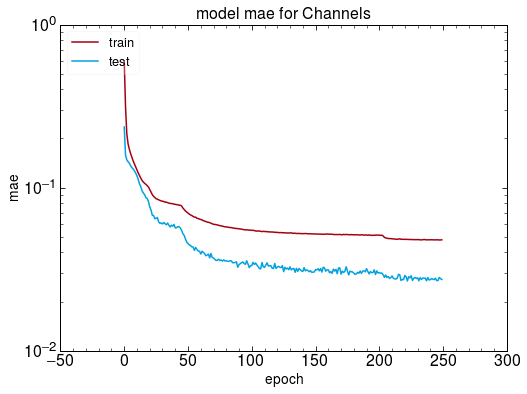

In [68]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_p1_d02.history['mse'])
plt.plot(history_p1_d02.history['val_mse'])
plt.title('model mse for Channels')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


    # summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_p1_d02.history['mae'])
plt.plot(history_p1_d02.history['val_mae'])
plt.title('model mae for Channels')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

<Figure size 576x432 with 0 Axes>

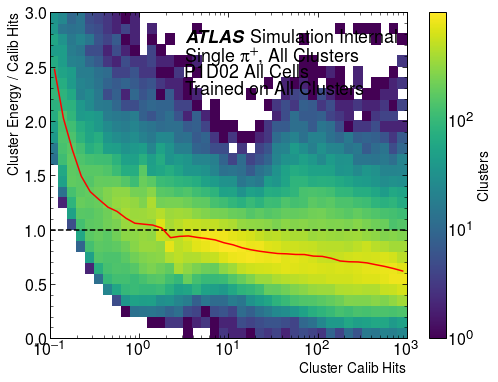

In [70]:
xcenter, medReg_p1_d02 = ru.responsePlot(pp[pp.train & pp.cleanEmpty & pp.cleanLeading].cluster_ENG_CALIB_TOT, pp[pp.train & pp.cleanEmpty & pp.cleanLeading].predict_p1_d02_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_p1_d02_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'P1D02 All Cells'},
                             {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

<Figure size 576x432 with 0 Axes>

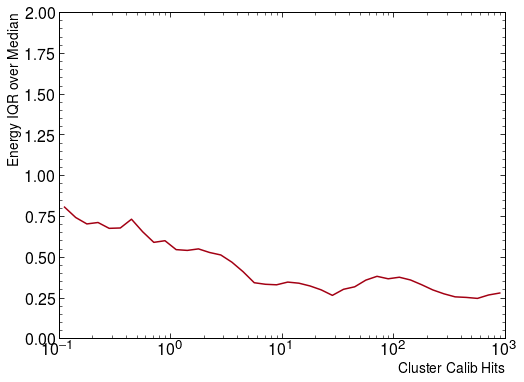

In [21]:
xcenter, iqrOverMed_p1_d02 = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].predict_p1_d02_EoverCalib, statistic='iqrOverMed')

Ok, try densenet?

In [30]:
from util import densenet as dn
def dense_model(droprate=.5):
    with strategy.scope():
        # EMB1 image (convolutional)
        emb1_dense = dn.DenseNet(input_shape=(128,4,1), depth=13, 
                             nb_dense_block=1, growth_rate=16, dropout_rate=droprate,
                             include_top=False, model_prefix='emb1_')
        input1 = emb1_dense.input
        x1 =  emb1_dense.output
        x1 = Flatten(name='emb1_flatten')(x1)
        x1 = Dense(128, activation='relu', name='emb1_dense')(x1)

        # EMB23 image (convolutional)
        # input2 = Input(shape=(16,16,2), name='emb23_input')
        emb23_dense = dn.DenseNet(input_shape=(16,16,2), depth=13, 
                                nb_dense_block=1, growth_rate=16, dropout_rate=droprate,
                                include_top=False, model_prefix='emb23_')
        input2 = emb23_dense.input
        x2 =  emb23_dense.output
        x2 = Flatten(name='emb23_flatten')(x2)
        x2 = Dense(128, activation='relu', name='emb23_dense')(x2)

        # tiles image (convolutional)
        # input3 = Input(shape=(4,4,3), name='tiles_input')
        tiles_dense = dn.DenseNet(input_shape=(4,4,3), depth=13, 
                                nb_dense_block=1, growth_rate=16, dropout_rate=droprate,
                                include_top=False, model_prefix='tiles_')
        input3 = tiles_dense.input
        x3 =  tiles_dense.output
        x3 = Flatten(name='tiles_flatten')(x3)
        x3 = Dense(128, activation='relu', name='tiles_dense')(x3)

        # concatenate outputs from the two networks above
        x = concatenate([x1, x2, x3], name='concatenate') 
        x = Dropout(droprate, name='concate_dropout_5')(x)
        x = Dense(64, name='concated_dense_1')(x)    
        x = Activation('relu')(x)
        x = Dropout(droprate, name='dense_dropout_6')(x)

        # final output
        output = Dense(1, activation=stretched_tanh, name='dense_output')(x)
        # output = 5*tf.math.tanh(x)   # 0 to +5 range

        model = Model(inputs = [input1, input2, input3], outputs = [output])

        # compile model
        # model = multi_gpu_model(model, gpus=4)
        model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])        
        return model

In [31]:
model_dense_d02 = dense_model(0.2)
model_dense_d02.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 4, 1)]  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 16, 16, 2)]  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 4, 4, 3)]    0                                            
__________________________________________________________________________________________________
emb1_initial_conv2D (Conv2D)    (None, 128, 4, 32)   128         input_10[0][0]                   
____________________________________________________________________________________________

In [32]:
history_dense_d02 = model_dense_d02.fit([pcellsE1_EMB1G_channels[pp.train], 
                                pcellsE23_EMB2G_channels[pp.train], 
                                pcellsT123_T1G_channels[pp.train]],
                                pp[pp.train].s_logECalib.to_numpy(),
                                validation_data=([pcellsE1_EMB1G_channels[pp.val], 
                                                    pcellsE23_EMB2G_channels[pp.val], 
                                                    pcellsT123_T1G_channels[pp.val]], 
                                                    pp[pp.val].s_logECalib.to_numpy()),
                                epochs=100,
                                batch_size = 128*ngpu,
                                verbose=2
                                # use_multiprocessing=False
                                )

Train on 305176 samples, validate on 43598 samples
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
305176/305176 - 37s - loss: 0.5141 - mae: 0.2682 - mse: 0.4965 - val_loss: 0.0511 - val_mae: 0.1593 - val_mse: 0.0355
Epoch 2/100
305176/305176 - 30s - loss: 0.0415 - mae: 0.1355 - mse: 0.0276 - val_loss: 0.0342 - val_mae: 0.1274 - val_mse: 0.0220
Epoch 3/100
305176/305176 - 30s - loss: 0.0247 - mae: 0.0889 - mse: 0.0142 - val_loss: 0.0127 - val_mae: 0.0466 - val_mse: 0.0037
Epoch 4/100
305176/305176 - 29s - loss: 0.0148 - mae: 0.0637 - mse: 0.0073 - val_loss: 0.0088 - val_mae: 0.0394 - val_mse: 0.0026
Epoch 5/100
305176/305176 - 30s - loss: 0.0108 - mae: 0.0541 - mse: 0.0057 - val_loss: 0.0062 - val_mae: 0.0337 - val_mse: 0.

In [33]:
print('test')

test


In [34]:
pp['predict_dense_d02'] = 10.**(denorm(model_dense_d02.predict([pcellsE1_EMB1G_channels, pcellsE23_EMB2G_channels, pcellsT123_T1G_channels]), xmax = calib_max, xmin = calib_min))
pp['predict_dense_d02_EoverCalib'] = pp.predict_dense_d02 / pp.cluster_ENG_CALIB_TOT

<Figure size 576x432 with 0 Axes>

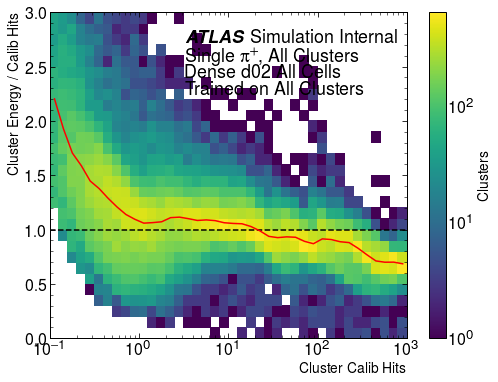

In [36]:
xcenter, medReg_dense_d02 = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_dense_d02_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_dense_d02_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'Dense d02 All Cells'},
                             {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])